In [1]:
from granad import core, wrappers
import jax.numpy as jnp
import jax
import numpy as np

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Setting up graphene nanoflakes.

This example demonstrates the setup of a basic simulation. It shows how stacks, the base concept of the system, are made.

**Contents of this notebook:** \
Example 1.1. Initialize a simple graphene flake \
Example 1.2. Create a more complex flake\
Example 1.3. Utilize additional stack parameters

----------------- 

Here, we will present how you can specify the parameters of the flake you want to construct.
But firstly: what we call a flake, is actually represented by a stack in our toolbox. Each stack is made up of layers comprising, in turn, individual orbitals. 

The only mandatory parameter to create a stack is its layers (although it can be only one layer, as it is in the case of a simple graphene flake, like the one we will use for the sake of this tutorial). The layer is formed based on the parameters which will be showacased in example [1.1.](#example-1.1.-initialize-a-graphene-flake).

### Example 1.1. Initialize a graphene flake

To construct a single graphene sheet, we define the its parameters and call the `get_stack()` function.

The C-C distance is the distance between each to neighboring carbon atoms:

In [2]:
cc_distance = 2.46 / np.sqrt(3)

The geometrical specification of the lattice and use it to obtain the orbitals of chosen shape (in this case, an equilateral triangle with 3 heaxgon units forming its base):

In [3]:
edge_type = 'armchair'
graphene_armchair_unit = wrappers.unit_cells[edge_type] * cc_distance
graphene_armchair_scale = wrappers.scales[edge_type] * cc_distance
orbs = core.get_orbitals(core.triangle(3), graphene_armchair_unit, graphene_armchair_scale, 'pz', shift = jnp.zeros(3))

We are almost there, but we have to do one last thing before we can make a real stack. Most variables in GRANAD are configurable, which is potent but may also seem cumbersome. The functions available specify a lot of often-used variables; however, currently, we have no way of knowing how different carbon atoms interact with each other, so we must provide GRANAD with the information.

Thus, we must specify the TB-hopping parameters and coulomb interactions. We do so by defining distance-based functions via the `neighbour_coupling()` function.

In [4]:
orbs_in_uc = cc_distance * jnp.array(
    [
        [0, 0, 0],
        [1, 0, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
    ]
)
hopping = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [0, -2.66 + 0j])
coulomb = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [16.522 + 0j, 8.64 + 0j, 5.333 + 0j], lambda r :  27.21*0.52918/r + 0j)
h_dict = { ('pz', 'pz') : hopping }
c_dict = { ('pz', 'pz') : coulomb }

Finally, we can create the stack itself and visualize the geometry with the `show_eigenstate()` function, and the energy landscape (with colors indicating how many electrons each level contains) by calling the `show_energies()` function.

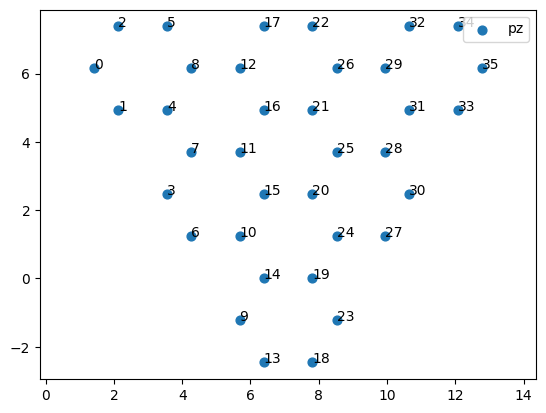

/home/julia/.local/lib/python3.10/site-packages/jax/_src/array.py:387: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


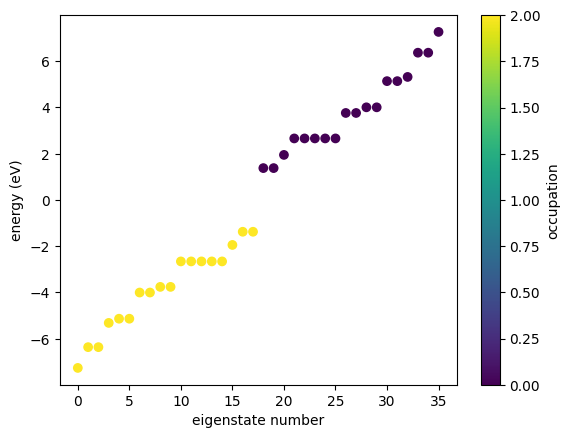

In [5]:
stack = core.get_stack(orbs, h_dict, c_dict)

wrappers.show_eigenstate2D(stack, indicate_size = False)
wrappers.show_energies(stack)

### Example 1.2. Create a more complex flake

A more advanced flake, not only in terms of structure, comprises more layers and/or makes use of more of the layer-creation parameters.

Namely, we can construct a 3D stack where the the upper layer is shifted 4 A above the lower layer (both layers are in the xy-plane).

In [6]:
cc_distance = 2.46/np.sqrt(3)            
graphene_armchair_unit = wrappers.unit_cells['armchair'] * cc_distance
graphene_armchair_scale = wrappers.scales['armchair'] * cc_distance
orbs_a = core.get_orbitals(core.triangle(5), graphene_armchair_unit, graphene_armchair_scale, 'a', shift = jnp.zeros(3))

graphene_zigzag_unit = wrappers.unit_cells['zigzag'] * cc_distance
graphene_zigzag_scale = wrappers.scales['zigzag'] * cc_distance
orbs_z = core.get_orbitals(core.hexagon(4, 8), graphene_zigzag_unit, graphene_zigzag_scale, 'z', shift = jnp.array([0, 4, 0]))

orbs = np.concatenate((orbs_a, orbs_z))

Now, analogously to the single-layer flake in example [1.1.](#example-1.1.-initialize-a-graphene-flake), we specify the hopping rates and coulomb couplings, but taking into account the interlayer relations.

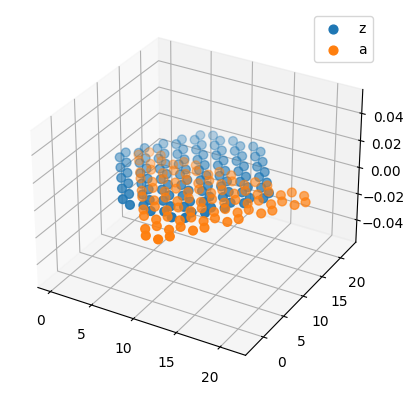

/home/julia/.local/lib/python3.10/site-packages/jax/_src/array.py:387: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


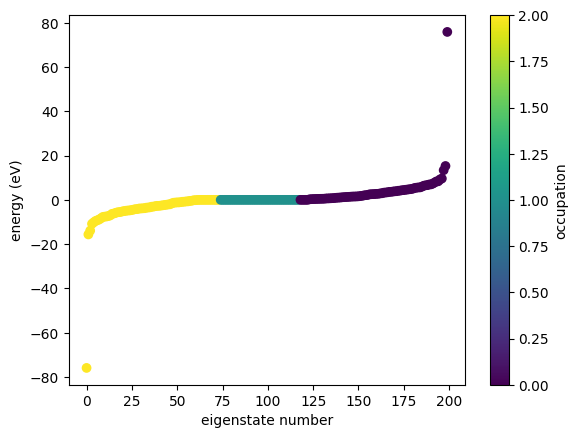

In [7]:
h_dict = {}
c_dict = {}
h_dict[('a', 'z')] = jax.jit(lambda d : 2.66*(0.5/d)**2 + 0.0j)
c_dict[('a', 'z')] = jax.jit(lambda d : 0j) 


orbs_in_uc = cc_distance * jnp.array(
    [
        [0, 0, 0],
        [1, 0, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
    ]
)
h_dict[('a', 'a')] = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [0, -2.66 + 0j])
c_dict[('a', 'a')] = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [16.522 + 0j, 8.64 + 0j, 5.333 + 0j], lambda r :  27.21*0.52918/r + 0j)
h_dict[('z', 'z')] = core.neighbour_coupling( graphene_zigzag_unit, orbs_in_uc, [0, -2.66 + 0j])
c_dict[('z', 'z')] = core.neighbour_coupling( graphene_zigzag_unit, orbs_in_uc, [16.522 + 0j, 8.64 + 0j, 5.333 + 0j], lambda r :  27.21*0.52918/r + 0j)
stack = core.get_stack( orbs, h_dict, c_dict )

wrappers.show_eigenstate3D(stack, indicate_size = False, annotate_hilbert = False)
wrappers.show_energies(stack)

### Example 1.3. Utilize additional stack parameters

To demostrate another possibility of the stack system, we build one where the initial transition is excited, meaning we want to "lift" an electron from the lower to the upper.

You can compare the new visualization with the energy landscape from example [1.1.](#example-1.1.-initialize-a-graphene-flake) to check that we really have an excited state.

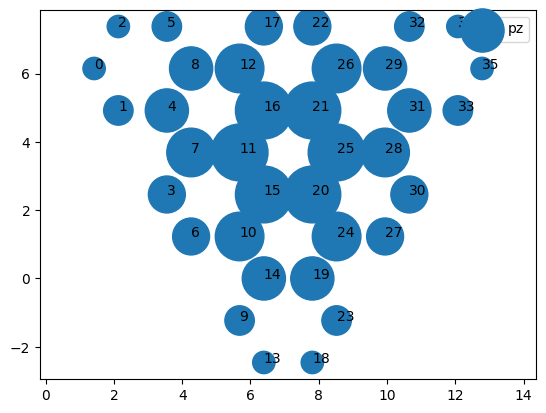

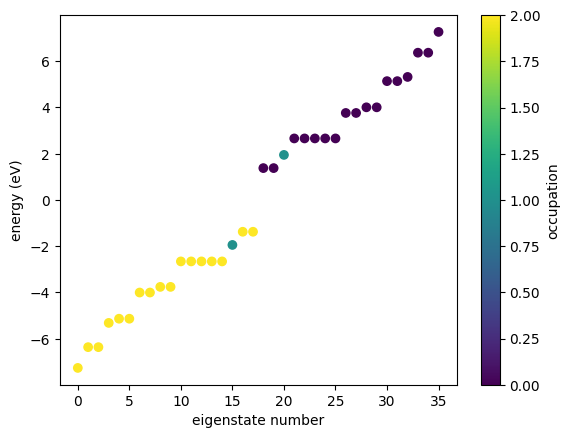

In [8]:
cc_distance = 2.46 / np.sqrt(3)
edge_type = 'armchair'
graphene_armchair_unit = wrappers.unit_cells[edge_type] * cc_distance
graphene_armchair_scale = wrappers.scales[edge_type] * cc_distance
orbs = core.get_orbitals(core.triangle(3), graphene_armchair_unit, graphene_armchair_scale, 'pz', shift = jnp.zeros(3))
orbs_in_uc = cc_distance * jnp.array(
    [
        [0, 0, 0],
        [1, 0, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
        [-1 / 2, -jnp.sqrt(3) / 2, 0],
    ]
)
hopping = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [0, -2.66 + 0j])
coulomb = core.neighbour_coupling( graphene_armchair_unit, orbs_in_uc, [16.522 + 0j, 8.64 + 0j, 5.333 + 0j], lambda r :  27.21*0.52918/r + 0j)
h_dict = { ('pz', 'pz') : hopping }
c_dict = { ('pz', 'pz') : coulomb }

stack = core.get_stack(orbs, h_dict, c_dict, from_state = 2, to_state = 3)

wrappers.show_eigenstate2D(stack, indicate_size = True)
wrappers.show_energies(stack)